In [18]:
import pandas as pd 
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus

user = "SA"
password = quote_plus("CarlAxel@1417")
server = 'localhost:1433'
database = 'AdventureWorks2025'
driver = quote_plus("ODBC Driver 18 for SQL server")


connection_string = (
    f"mssql+pyodbc://{user}:{password}@{server}/{database}"
    f"?driver={driver}&Encrypt=yes&TrustServerCertificate=yes"
)

engine = create_engine(connection_string)


try:
    with engine.connect():
        print("Anslutning till SQL Server lyckades")
except Exception as e:
    print("Kunde inte ansluta", e)


Anslutning till SQL Server lyckades


C:\Users\marcu\AppData\Local\Temp\ipykernel_24452\3423618423.py:21: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  with engine.connect():


In [19]:
def query_df(sql: str):
    with engine.connect() as conn:
        return pd.read_sql(text(sql),conn)

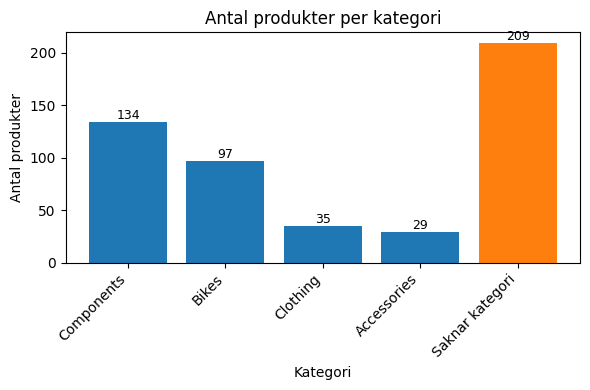

,Kategori,SummaKategori
0,Bikes,"$94,651,173"
1,Components,"$11,802,593"
2,Clothing,"$2,120,543"
3,Accessories,"$1,272,073"


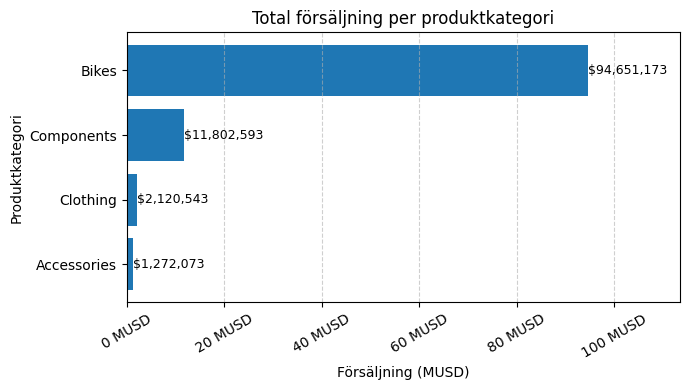

In [ ]:
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

## Uppgift 1:
## Antal produkter per kategori
## Affärsfråga: Hur många produkter finns i varje kategori?

query_1 = """
SELECT 
    COALESCE (pc.Name, 'Saknar kategori') AS Kategori,
    COUNT(p.ProductID) AS AntalProdukter
FROM 
    Production.Product p
LEFT JOIN Production.ProductSubcategory ps 
    ON p.ProductSubcategoryID = ps.ProductSubcategoryID
LEFT JOIN Production.ProductCategory pc 
    ON ps.ProductCategoryID = pc.ProductCategoryID
GROUP BY 
    COALESCE(pc.Name, 'Saknar kategori')
ORDER BY 
    CASE WHEN COALESCE(pc.Name, 'Saknar kategori') = 'Saknar kategori' THEN 1 ELSE 0 END,
    AntalProdukter DESC
"""
query_1_df = query_df(query_1)
# display(query_1_df)

colors = [
    "tab:orange" if kategori == "Saknar kategori" else "tab:blue"
    for kategori in query_1_df["Kategori"]
]
plt.figure(figsize=(6, 4))
bars = plt.bar(query_1_df["Kategori"], query_1_df["AntalProdukter"], color=colors)
plt.title("Antal produkter per kategori")
plt.xlabel("Kategori")
plt.ylabel("Antal produkter")
plt.xticks(rotation=45, ha="right")

#Etiketter
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f"{int(height)}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

## Uppgift 2:
## Försäljning per produktkategori
## Affärsfråga: Vilka produktkategorier genererar mest intäkter?

query_2 = """
SELECT 
    COALESCE (pc.Name, 'Saknar kategori') AS Kategori,
    SUM(LineTotal) AS SummaKategori
FROM 
    Sales.SalesOrderDetail sod
INNER JOIN Production.Product p
    ON sod.ProductID = p.ProductID
LEFT JOIN Production.ProductSubcategory ps 
    ON p.ProductSubcategoryID = ps.ProductSubcategoryID
LEFT JOIN Production.ProductCategory pc 
    ON ps.ProductCategoryID = pc.ProductCategoryID
GROUP BY 
    COALESCE(pc.Name, 'Saknar kategori')
ORDER BY 
    CASE WHEN COALESCE(pc.Name, 'Saknar kategori') = 'Saknar kategori' THEN 1 ELSE 0 END,
    SummaKategori DESC;
"""

query_2_df = query_df(query_2)
display(query_2_df.style.format({"SummaKategori": "${:,.0f}"}).set_caption("Försäljning per produktkategori (USD)"))

plt.figure(figsize=(7, 4))

bars = plt.barh(
    query_2_df["Kategori"],
    query_2_df["SummaKategori"]
)

plt.title("Total försäljning per produktkategori")
plt.xlabel("Försäljning (MUSD)")
plt.ylabel("Produktkategori")

# Högsta värdet överst
plt.gca().invert_yaxis()

# Vertikala hjälplinjer
plt.grid(axis="x", linestyle="--", alpha=0.6)

#Formattering x-axel
ax = plt.gca()
ax.xaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f"{x/1_000_000:.0f} MUSD")
)
plt.xticks(rotation=30)

# Extra utrymme så texten inte kapas
max_value = query_2_df["SummaKategori"].max()
plt.xlim(0, max_value * 1.2)

# Lägg exakta värden på staplarna
for bar in bars:
    width = bar.get_width()
    plt.text(
        width,
        bar.get_y() + bar.get_height() / 2,
        f"${width:,.0f}",
        va="center",
        ha="left",
        fontsize=9
    )

plt.tight_layout()
plt.show()

##Försäljningstrend över tid
##Affärsfråga: Hur har försäljningen utvecklats över tid?


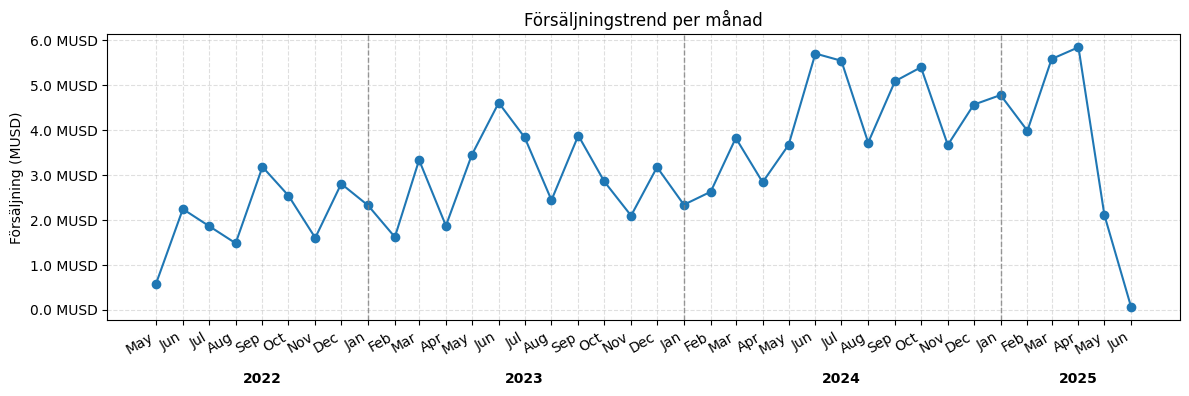

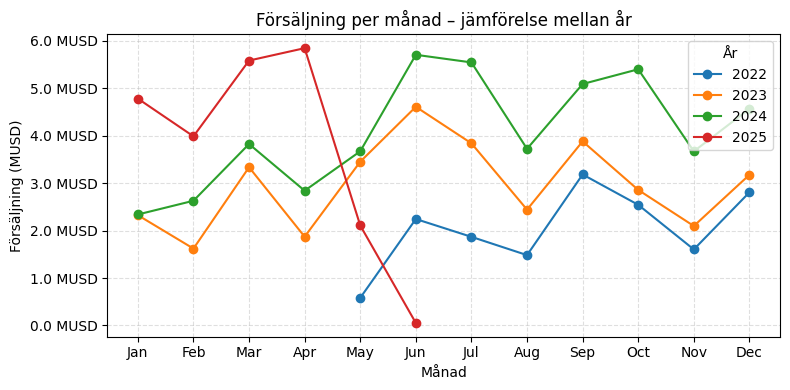

In [62]:
import matplotlib.dates as mdates

## Uppgift
## Försäljningstrend över tid
## Affärsfråga: Hur har försäljningen utvecklats över tid?

query_3 ="""
SELECT 
    DATEFROMPARTS(YEAR(OrderDate), MONTH(OrderDate), 1) AS OrderMonth,
    SUM(TotalDue) AS TotalForsaljning
FROM 
    Sales.SalesOrderHeader
GROUP BY 
    DATEFROMPARTS(YEAR(OrderDate), MONTH(OrderDate), 1)
ORDER BY 
    OrderMonth;
""" 
query_3_df = query_df(query_3)
#query_3_df.head()
#query_3_df.dtypes

#Gör om OrderMonth från object till datetime
query_3_df["OrderMonth"] = pd.to_datetime(query_3_df["OrderMonth"])

#Ska vara sorterad men säkerställer
#query_3_df = query_3_df.sort_values("OrderMonth")

fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(
    query_3_df["OrderMonth"],
    query_3_df["TotalForsaljning"],
    marker="o"
)

ax.set_title("Försäljningstrend per månad")
#ax.set_xlabel("Tid")

#Formatera y-axeln
ax.yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda y, _: f"{y/1_000_000:.1f} MUSD")
)
ax.set_ylabel("Försäljning (MUSD)")

# Månader som ticklabels
ax.set_xticks(query_3_df["OrderMonth"])
ax.set_xticklabels(
    query_3_df["OrderMonth"].dt.strftime("%b"),
    rotation=30, ha="right"
)

ax.grid(True, linestyle="--", alpha=0.4)

years = query_3_df["OrderMonth"].dt.year.unique() #lista med år i kronolisk ordning

for year in years:
    year_data = query_3_df[query_3_df["OrderMonth"].dt.year == year]
    mid_date = year_data["OrderMonth"].iloc[len(year_data) // 2]

    ax.text(
        mid_date, -0.18, # placering under x-axeln
        str(year), ha="center", va="top",
        transform=ax.get_xaxis_transform(),
        fontsize=10, fontweight="bold"
    )

# Vertikala linjer vid årsskiften (brytmarkeringar)
min_year = query_3_df["OrderMonth"].dt.year.min()
max_year = query_3_df["OrderMonth"].dt.year.max()

for y in range(min_year + 1, max_year + 1):
    boundary = pd.Timestamp(y, 1, 1)
    # Rita bara om gränsen ligger inom vår tidsperiod
    if query_3_df["OrderMonth"].min() < boundary < query_3_df["OrderMonth"].max():
        ax.axvline(boundary, linestyle="--", linewidth=1, alpha=0.8, color="tab:gray")

plt.subplots_adjust(bottom=0.25)
plt.tight_layout()
plt.show()

# År över varandra
df_y_m = query_3_df.copy()
df_y_m["Year"] = df_y_m["OrderMonth"].dt.year
df_y_m["Month"] = df_y_m["OrderMonth"].dt.month
df_y_m["MonthName"] = df_y_m["OrderMonth"].dt.strftime("%b")

plt.figure(figsize=(8, 4))

for year, data in df_y_m.groupby("Year"):
    plt.plot(
        data["Month"],
        data["TotalForsaljning"],
        marker="o",
        label=str(year)
    )

plt.title("Försäljning per månad – jämförelse mellan år")
plt.xlabel("Månad")
plt.ylabel("Försäljning (MUSD)")

# Månadsetiketter
plt.xticks(
    ticks=range(1, 13),
    labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun",
            "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
)

# Y-axel i MUSD
ax = plt.gca()
ax.yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda y, _: f"{y/1_000_000:.1f} MUSD")
)

plt.legend(title="År")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()